In [205]:
import os, sys
from functools import reduce
from sys import stdout

import numpy, scipy
from scipy import linalg

from pyscf.tools.dump_mat import dump_rec

def solve_h(epsilon=None, delta=None, vcoup=None, dcoup=None):
    hh = []
    hh.append([0.0,     vcoup, dcoup])
    hh.append([vcoup, epsilon, dcoup])
    hh.append([dcoup,   dcoup, delta])
    hh = numpy.array(hh)
    e, c = scipy.linalg.eigh(hh)
    return e, c, hh

def solve_h1(epsilon=None, delta=None, vcoup=None, dcoup=None):
    hh = []
    hh.append([0.0,   dcoup])
    hh.append([dcoup, delta])
    hh = numpy.array(hh)

    e, c = scipy.linalg.eigh(hh)
    e0 = e[0]
    c0 = [c[0, 0], 0.0, c[0, 1]]
    c0 = numpy.array(c0)
    return e0, c0

def solve_h2(epsilon=None, delta=None, vcoup=None, dcoup=None):
    hh = []
    hh.append([epsilon, dcoup])
    hh.append([dcoup,   delta])
    hh = numpy.array(hh)

    e, c = scipy.linalg.eigh(hh)
    e0 = e[0]
    c0 = [0.0, c[0, 0], c[0, 1]]
    c0 = numpy.array(c0)
    return e0, c0

def get_data(epsilon=None, delta=None, vcoup=None, dcoup=None):
    e1, c1, h = solve_h(epsilon, delta, vcoup, dcoup)

    e2, c2 = solve_h1(epsilon, delta, vcoup, dcoup)
    e3, c3 = solve_h2(epsilon, delta, vcoup, dcoup)

    coeff = numpy.vstack((c2, c3)).T
    heff  = reduce(numpy.dot, (coeff.T, h, coeff))
    seff  = reduce(numpy.dot, (coeff.T, coeff))
    
    e4, c4 = scipy.linalg.eigh(heff, seff)
    
    res = {
        "e1": e1, "c1": c1, "h1": h, "heff": heff,
        "e2": e2, "c2": c2,
        "e3": e3, "c3": c3,
        "e4": e4, "c4": c4,
    }

    return res

nn = 21
e_list = numpy.linspace(0.0, 0.8, nn)
d_list = numpy.linspace(0.0, 0.8, nn)
v_list = numpy.linspace(0.0, 2.0, nn)

data = {}

for e in e_list:
    for d in d_list:
        for v in v_list:
            res = get_data(epsilon=e, delta=1.0, vcoup=v, dcoup=d)
            data["%6.4f-%6.4f-%6.4f" % (e, d, v)] = res


In [206]:
from matplotlib import pyplot
import matplotlib as mpl
from matplotlib import cm

params = {
        "font.size":       18,
        "axes.titlesize":  20,
        "axes.labelsize":  20,
        "legend.fontsize": 18,
        "xtick.labelsize": 14,
        "ytick.labelsize": 14,
        "figure.subplot.wspace":0.0,
        "figure.subplot.hspace":0.0,
        "axes.spines.right": True,
        "axes.spines.top":   True,
        "xtick.direction":'in',
        "ytick.direction":'in',
        "text.usetex": True,
        "font.family": "serif",
        'text.latex.preamble': r"\usepackage{amsmath}"
}
mpl.rcParams.update(params)

colors = ["2ab7ca", "fe4a49","fed766","00cc66","8c5383"]
colors = ["#"+color for color in colors]

one_step_dict = {
    "linestyle": "-",
    "marker": "o",
    "markersize": 3,
    "markevery": 3
}

two_step_dict = {
    "linestyle": "-.",
    "marker": ">",
    "markersize": 3,
    "markevery": 4
}

def plot_data(data, e=None, d=None, v=None, es=None, vs=None, ds=None, fig=None, axs=None):
    gen_key = lambda x, y, z: "%6.4f-%6.4f-%6.4f" % (x, y, z)

    if vs is not None:
        assert e is not None
        assert d is not None
        assert v is None

        assert es is None
        assert ds is None

        nv = len(vs)
        e1s = [data[gen_key(e, d, v)]["e1"] for v in vs]
        e4s = [data[gen_key(e, d, v)]["e4"] for v in vs]
        e1s = numpy.array(e1s).reshape(nv, 3)
        e4s = numpy.array(e4s).reshape(nv, 2)

        assert fig is not None
        assert axs is not None

        ax = axs[0]

        ax.plot(vs, e4s[:, 0], label=r"$E_0$ (two-step)", color=colors[0], **two_step_dict)
        ax.plot(vs, e4s[:, 1], label=r"$E_1$ (two-step)", color=colors[1], **two_step_dict)

        ax.plot(vs, e1s[:, 0], label=r"$E_0$ (exact)", color=colors[0], **one_step_dict)
        ax.plot(vs, e1s[:, 1], label=r"$E_1$ (exact)", color=colors[1], **one_step_dict)
        ax.plot(vs, e1s[:, 2], label=r"$E_2$ (exact)", color=colors[2], **one_step_dict)

        ax = axs[1]
        ax.plot(vs, numpy.abs(e1s[:, 0] - e1s[:, 0]), label=r"$E_0$ (one-step)", color=colors[0], **one_step_dict)
        ax.plot(vs, numpy.abs(e1s[:, 0] - e4s[:, 0]), label=r"$E_0$ (one-step)", color=colors[0], **two_step_dict)

        axs[0].text(0.05, 0.95, r"$\epsilon = %6.2f \Delta \quad \delta = %6.2f \Delta$" % (e, d), transform=axs[0].transAxes, va="top")
        axs[0].set_ylabel(r"Energy ($\Delta$)")
        axs[0].legend(
            loc=(0.0, 1.05), fancybox=False, framealpha=1.0,
            edgecolor='silver', frameon=False, fontsize=15, ncol=3
            )
        axs[0].grid(True, linestyle='-.')
        axs[0].set_ylim(-2, 2.5)
        axs[0].set_xlim(numpy.min(vs), numpy.max(vs))

        axs[1].set_ylabel(r"Energy Error ($\Delta$)")
        axs[1].set_xlabel(r"$V / \Delta$")
        axs[1].grid(True, linestyle='-.')
        name = "e-%.2f-vs-d-%.2f" % (e, d)

    elif es is not None:
        assert e is None
        assert d is not None
        assert v is not None

        assert vs is None
        assert ds is None
        
        ne = len(es)
        e1s = [data[gen_key(e, d, v)]["e1"] for e in es]
        e4s = [data[gen_key(e, d, v)]["e4"] for e in es]
        e1s = numpy.array(e1s).reshape(ne, 3)
        e4s = numpy.array(e4s).reshape(ne, 2)

        assert fig is not None
        assert axs is not None

        ax = axs[0]

        ax.plot(es, e4s[:, 0], label=r"$E_0$ (two-step)", color=colors[0], **two_step_dict)
        ax.plot(es, e4s[:, 1], label=r"$E_1$ (two-step)", color=colors[1], **two_step_dict)

        ax.plot(es, e1s[:, 0], label=r"$E_0$ (exact)", color=colors[0], **one_step_dict)
        ax.plot(es, e1s[:, 1], label=r"$E_1$ (exact)", color=colors[1], **one_step_dict)
        ax.plot(es, e1s[:, 2], label=r"$E_2$ (exact)", color=colors[2], **one_step_dict)

        ax = axs[1]
        ax.plot(es, numpy.abs(e1s[:, 0] - e1s[:, 0]), label=r"$E_0$ (one-step)", color=colors[0], **one_step_dict)
        ax.plot(es, numpy.abs(e1s[:, 0] - e4s[:, 0]), label=r"$E_0$ (one-step)", color=colors[0], **two_step_dict)

        axs[0].text(0.05, 0.95, r"$V = %6.2f \Delta \quad \delta = %6.2f \Delta$" % (v, d), transform=axs[0].transAxes, va="top")
        axs[0].set_ylabel(r"Energy ($\Delta$)")
        axs[0].legend(
            loc=(0.0, 1.05), fancybox=False, framealpha=1.0,
            edgecolor='silver', frameon=False, fontsize=15, ncol=3
            )
        axs[0].grid(True, linestyle='-.')
        axs[0].set_ylim(-2, 2.5)
        axs[0].set_xlim(numpy.min(es), numpy.max(es))

        axs[1].set_ylabel(r"Energy Error ($\Delta$)")
        axs[1].set_xlabel(r"$\epsilon / \Delta$")
        axs[1].grid(True, linestyle='-.')
        name = "es-v-%.2f-d-%.2f" % (v, d)

    elif ds is not None:
        assert e is not None
        assert d is None
        assert v is not None

        assert es is None
        assert vs is None

        nd = len(ds)
        e1s = [data[gen_key(e, d, v)]["e1"] for d in ds]
        e4s = [data[gen_key(e, d, v)]["e4"] for d in ds]

        e1s = numpy.array(e1s).reshape(nd, 3)
        e4s = numpy.array(e4s).reshape(nd, 2)

        assert fig is not None
        assert axs is not None

        ax = axs[0]
        ax.plot(ds, e4s[:, 0], label=r"$E_0$ (two-step)", color=colors[0], **two_step_dict)
        ax.plot(ds, e4s[:, 1], label=r"$E_1$ (two-step)", color=colors[1], **two_step_dict)
        
        ax.plot(ds, e1s[:, 0], label=r"$E_0$ (exact)", color=colors[0], **one_step_dict)
        ax.plot(ds, e1s[:, 1], label=r"$E_1$ (exact)", color=colors[1], **one_step_dict)
        ax.plot(ds, e1s[:, 2], label=r"$E_2$ (exact)", color=colors[2], **one_step_dict)

        ax = axs[1]
        ax.plot(ds, numpy.abs(e1s[:, 0] - e1s[:, 0]), label=r"$E_0$ (one-step)", color=colors[0], **one_step_dict)
        ax.plot(ds, numpy.abs(e1s[:, 0] - e4s[:, 0]), label=r"$E_0$ (one-step)", color=colors[0], **two_step_dict)

        axs[0].text(0.05, 0.95, r"$V = %6.2f \Delta \quad \epsilon = %6.2f \Delta$" % (v, e), transform=axs[0].transAxes, va="top")
        axs[0].set_ylabel(r"Energy ($\Delta$)")
        axs[0].legend(
            loc=(0.0, 1.05), fancybox=False, framealpha=1.0,
            edgecolor='silver', frameon=False, fontsize=15, ncol=3
            )

        axs[0].grid(True, linestyle='-.')
        axs[0].set_ylim(-2, 2.5)
        axs[0].set_xlim(numpy.min(ds), numpy.max(ds))

        axs[1].set_ylabel(r"Energy Error ($\Delta$)")
        axs[1].set_xlabel(r"$\delta / \Delta$")
        axs[1].grid(True, linestyle='-.')
        name = "e-%.2f-v-%.2f-ds" % (e, v)

    fig.tight_layout()
    fig.savefig("/Users/yangjunjie/Downloads/%s.pdf" % name)
    return fig, ax


(<Figure size 800x800 with 2 Axes>,
 <AxesSubplot:xlabel='$V / \\Delta$', ylabel='Energy Error ($\\Delta$)'>)

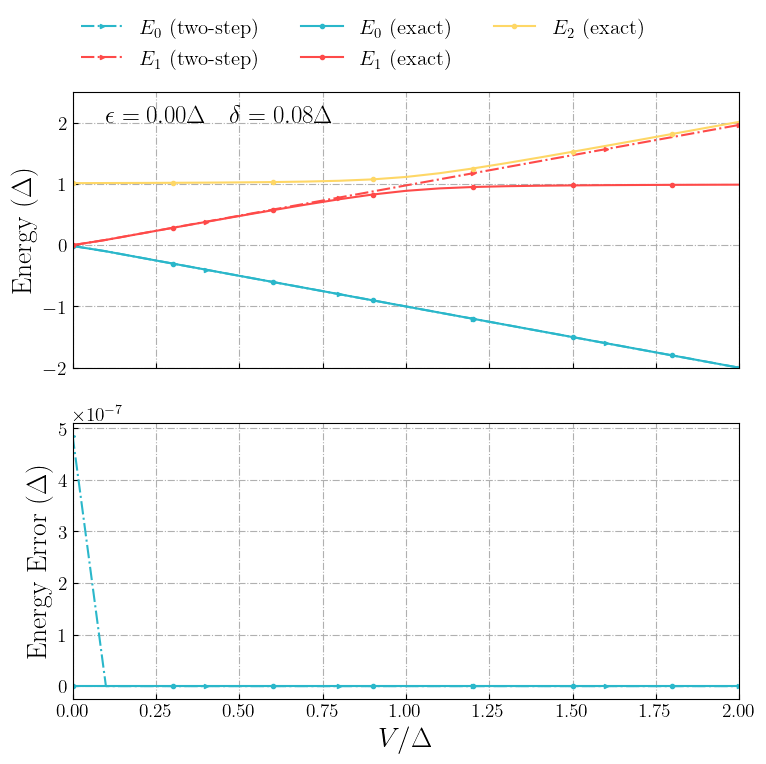

In [207]:
e = e_list[0]
d = d_list[2]

fig, axs = pyplot.subplots(2, 1, figsize=(8, 8), sharex=True)
plot_data(data, e=e, d=d, v=None, vs=v_list, es=None, ds=None, fig=fig, axs=axs)

(<Figure size 800x800 with 2 Axes>,
 <AxesSubplot:xlabel='$V / \\Delta$', ylabel='Energy Error ($\\Delta$)'>)

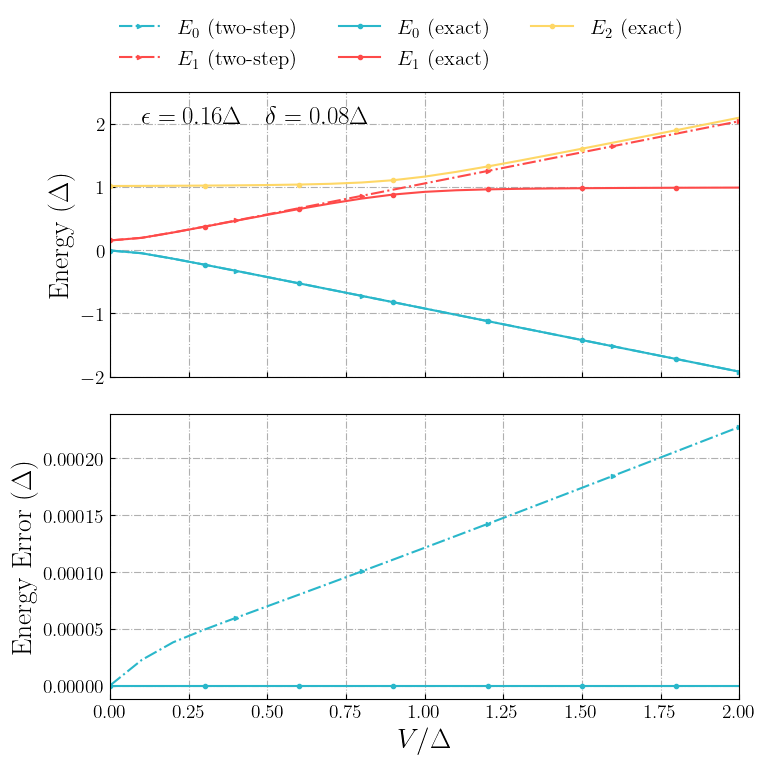

In [208]:
e = e_list[4]
d = d_list[2]

fig, axs = pyplot.subplots(2, 1, figsize=(8, 8), sharex=True)
plot_data(data, e=e, d=d, v=None, vs=v_list, es=None, ds=None, fig=fig, axs=axs)


(<Figure size 800x800 with 2 Axes>,
 <AxesSubplot:xlabel='$V / \\Delta$', ylabel='Energy Error ($\\Delta$)'>)

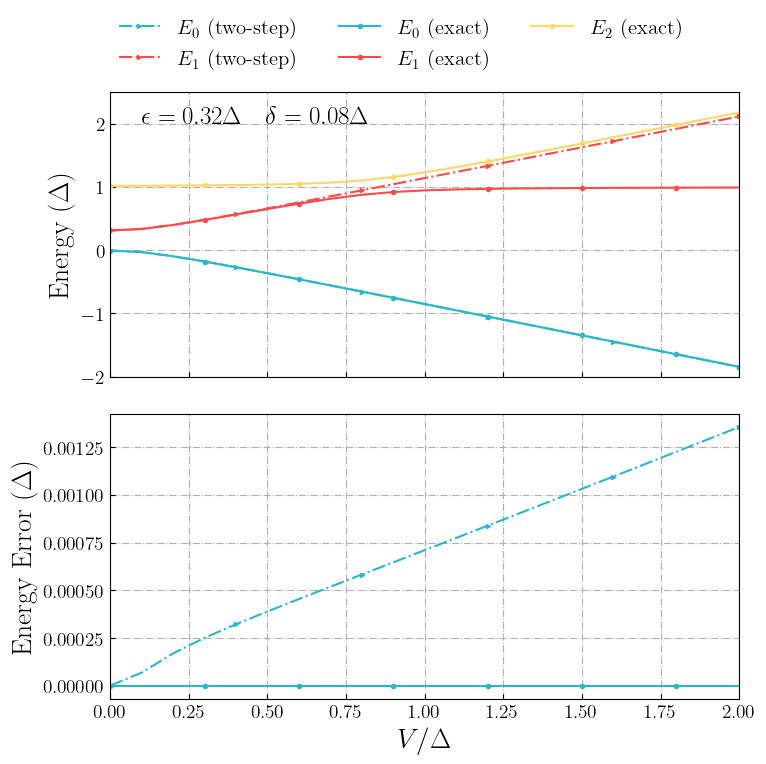

In [209]:
e = e_list[8]
d = d_list[2]

fig, axs = pyplot.subplots(2, 1, figsize=(8, 8), sharex=True)
plot_data(data, e=e, d=d, v=None, vs=v_list, es=None, ds=None, fig=fig, axs=axs)

(<Figure size 800x800 with 2 Axes>,
 <AxesSubplot:xlabel='$\\epsilon / \\Delta$', ylabel='Energy Error ($\\Delta$)'>)

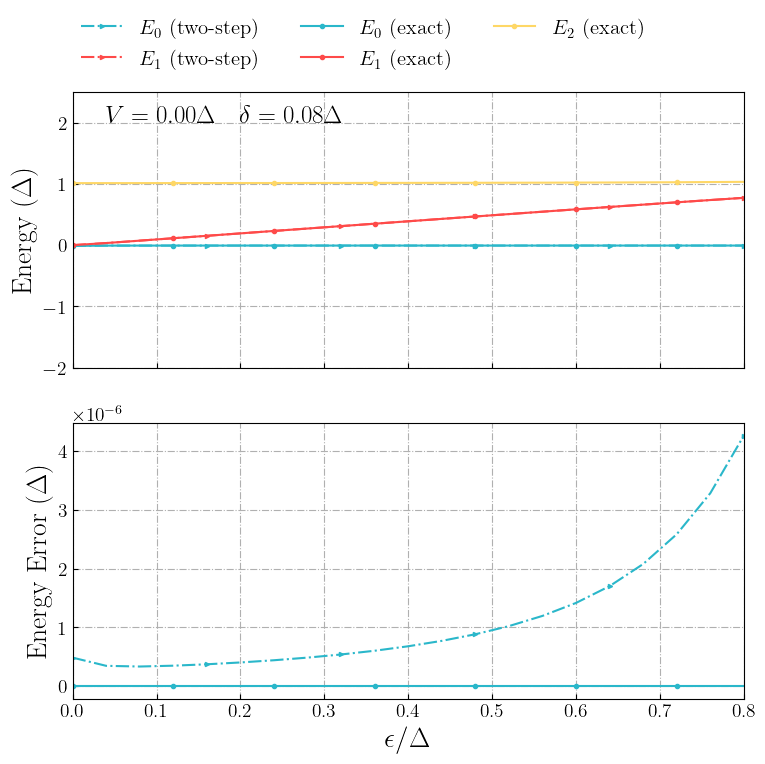

In [210]:
v = v_list[0]
d = d_list[2]

fig, axs = pyplot.subplots(2, 1, figsize=(8, 8), sharex=True)
plot_data(data, e=None, d=d, v=v, vs=None, es=e_list, ds=None, fig=fig, axs=axs)


(<Figure size 800x800 with 2 Axes>,
 <AxesSubplot:xlabel='$\\epsilon / \\Delta$', ylabel='Energy Error ($\\Delta$)'>)

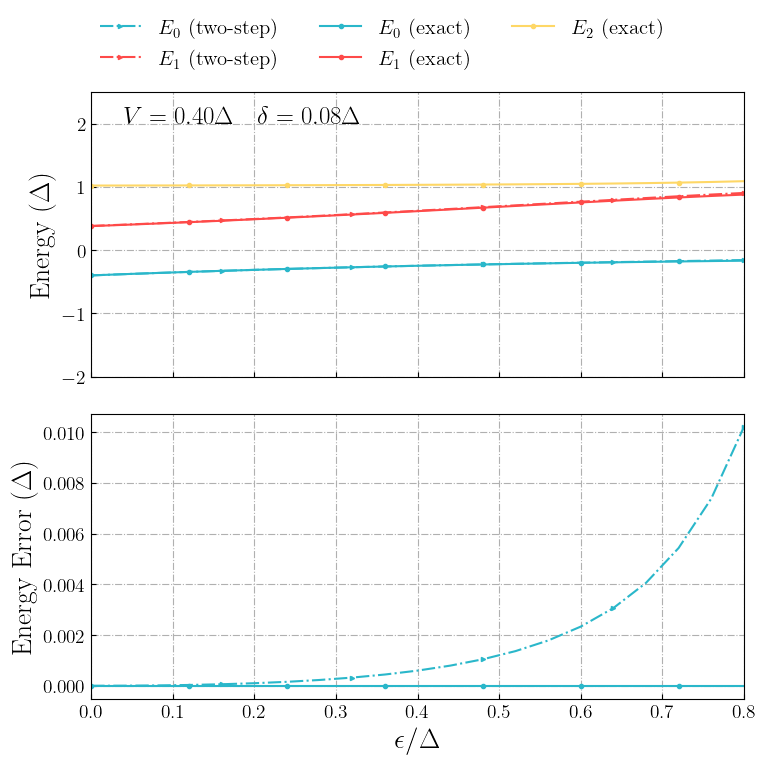

In [211]:
v = v_list[4]
d = d_list[2]

fig, axs = pyplot.subplots(2, 1, figsize=(8, 8), sharex=True)
plot_data(data, e=None, d=d, v=v, vs=None, es=e_list, ds=None, fig=fig, axs=axs)

(<Figure size 800x800 with 2 Axes>,
 <AxesSubplot:xlabel='$\\epsilon / \\Delta$', ylabel='Energy Error ($\\Delta$)'>)

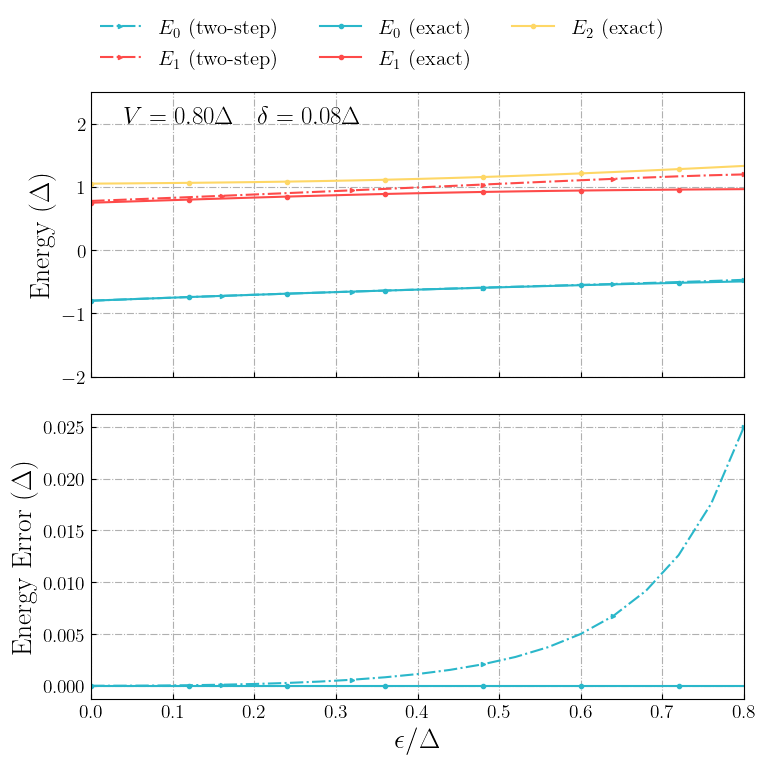

In [212]:
v = v_list[8]
d = d_list[2]

fig, axs = pyplot.subplots(2, 1, figsize=(8, 8), sharex=True)
plot_data(data, e=None, d=d, v=v, vs=None, es=e_list, ds=None, fig=fig, axs=axs)

(<Figure size 800x800 with 2 Axes>,
 <AxesSubplot:xlabel='$\\delta / \\Delta$', ylabel='Energy Error ($\\Delta$)'>)

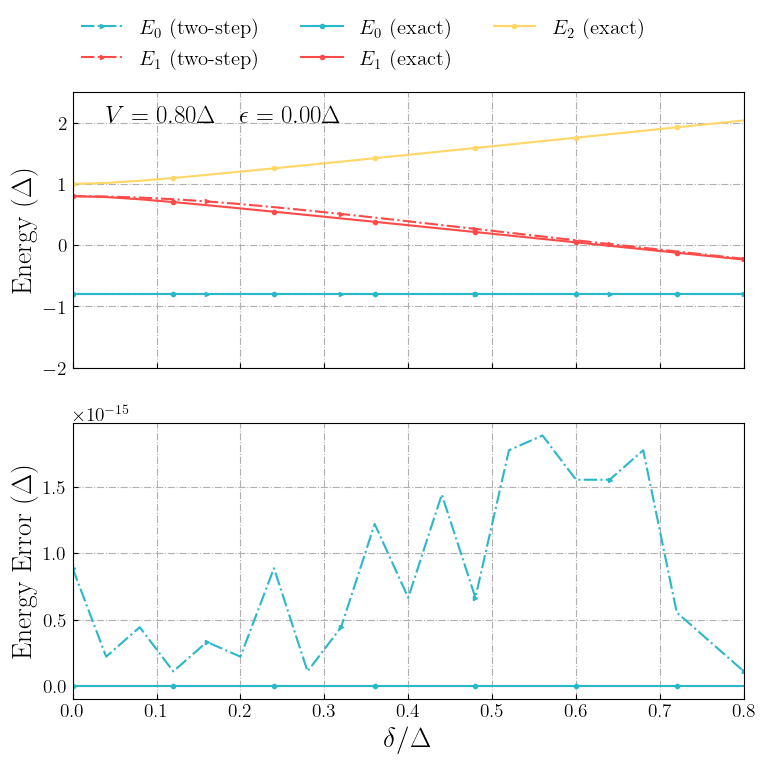

In [213]:
e = e_list[0]
v = v_list[8]

fig, axs = pyplot.subplots(2, 1, figsize=(8, 8), sharex=True)
plot_data(data, e=e, d=None, v=v, vs=None, es=None, ds=d_list, fig=fig, axs=axs)

(<Figure size 800x800 with 2 Axes>,
 <AxesSubplot:xlabel='$\\delta / \\Delta$', ylabel='Energy Error ($\\Delta$)'>)

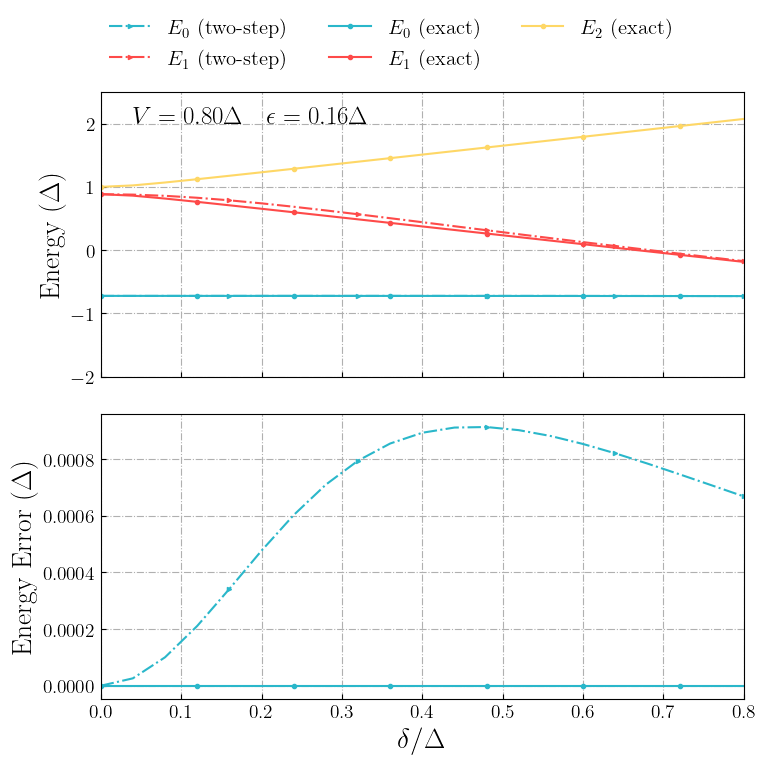

In [214]:
e = e_list[4]
v = v_list[8]

fig, axs = pyplot.subplots(2, 1, figsize=(8, 8), sharex=True)
plot_data(data, e=e, d=None, v=v, vs=None, es=None, ds=d_list, fig=fig, axs=axs)

(<Figure size 800x800 with 2 Axes>,
 <AxesSubplot:xlabel='$\\delta / \\Delta$', ylabel='Energy Error ($\\Delta$)'>)

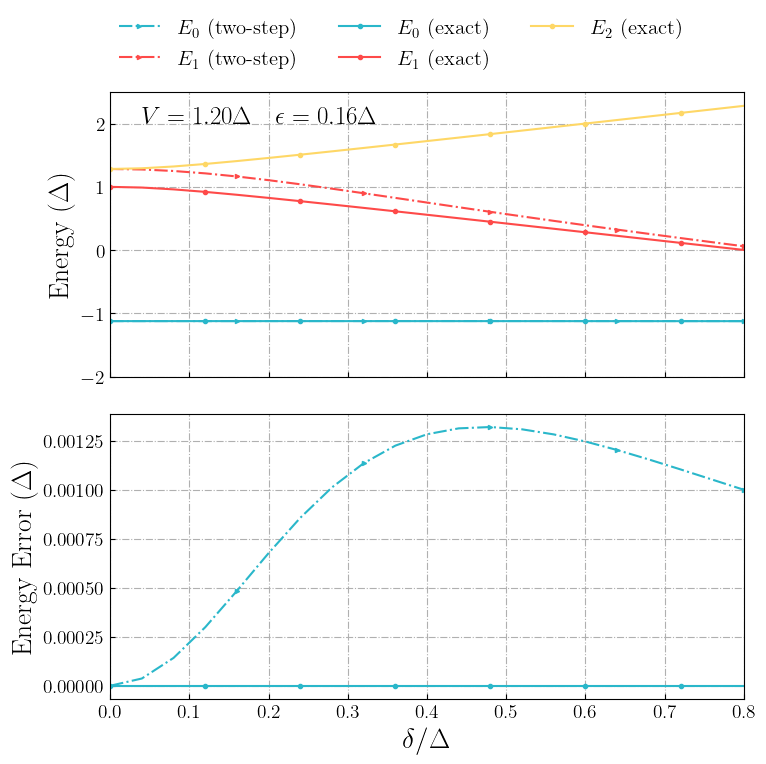

In [215]:
e = e_list[4]
v = v_list[12]

fig, axs = pyplot.subplots(2, 1, figsize=(8, 8), sharex=True)
plot_data(data, e=e, d=None, v=v, vs=None, es=None, ds=d_list, fig=fig, axs=axs)